In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import numpy as np
import glob, json

In [2]:
filename_to_type = {
    'taxi.csv': 'csv',
    'temp.csv': 'csv',
    # 'stock_prices.csv': 'csv',
    'nz_tourist_monthly.json': 'json',
    # 'eeg_chan20_2500.json': 'json',
    # 'chi_homicide_monthly.json': 'json',
    # 'stock_tsla_price.json': 'json',
    # 'power.csv': 'csv',
    'sine.csv': 'csv',
    # 'HF_mono_stat.csv': 'csv',
    'gasoline1.csv': 'csv',
    'gasoline2.csv': 'csv',
    'climate_jfk_tmax.json': 'json',
    'climate_lax_awnd.json': 'json',
    'monthly_beer_austria.csv': 'csv',
    'chi_homicide_weekly.json': 'json',
    # 'climate_sea_prcp.json': 'json',
    'eeg_chan10_2500.json': 'json',
    # 'stock_bac_volume.json': 'json',
    'usa_flights_weekly.json': 'json',
}

In [3]:
BASE_DIR = './datasets_user_study_1/'

def get_time_series(filename, type):
    if type == 'csv':
        # Get path to the file by searching recursively in the BASE_DIR
        path = glob.glob(BASE_DIR + '**/' + filename, recursive=True)[0]
        # Read the csv file
        df = pd.read_csv(path)
        # Get the value column
        time_series = df['value'].values
    elif type == 'json':
        # Get path to the file by searching recursively in the BASE_DIR
        path = glob.glob(BASE_DIR + '**/' + filename, recursive=True)[0]
        # Read the json file
        with open(path) as f:
            data = json.load(f)
        # Get the value column
        time_series = np.array(data)
    
    # Z-score the time series
    time_series = (time_series - time_series.mean()) / time_series.std()
    return time_series



In [4]:
# Plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

def plot_acf_wrapper(time_series, lags):
    # Plot ACF
    fig, ax = plt.subplots(figsize=(20, 5))
    plot_acf(time_series, lags=lags, ax=ax)
    plt.show()

taxi.csv


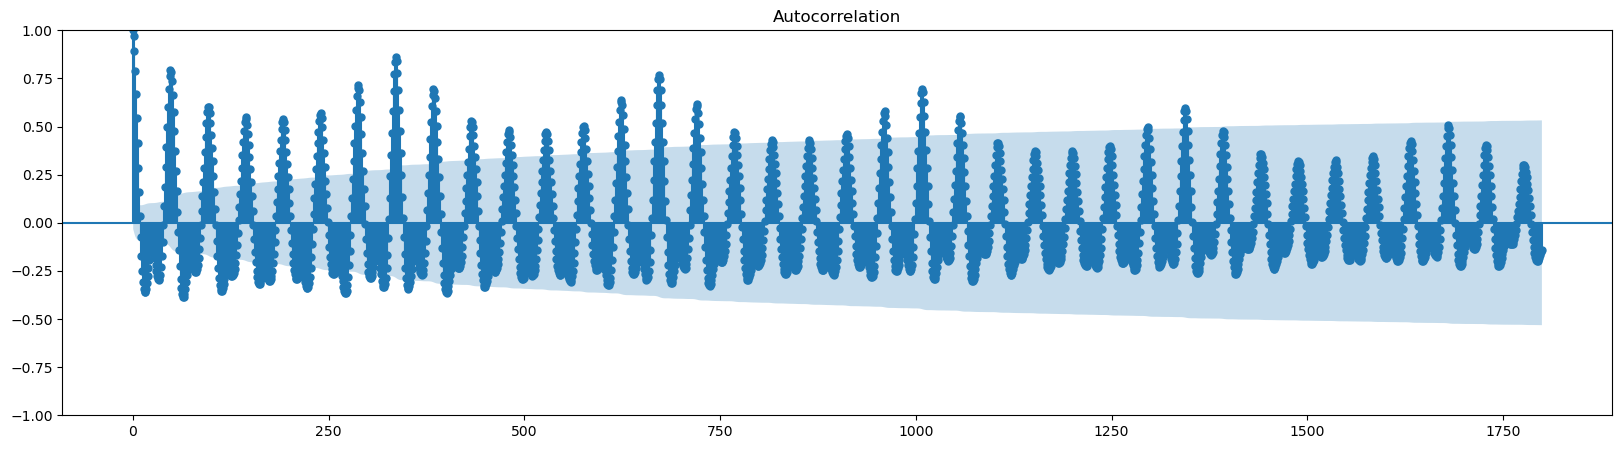

temp.csv


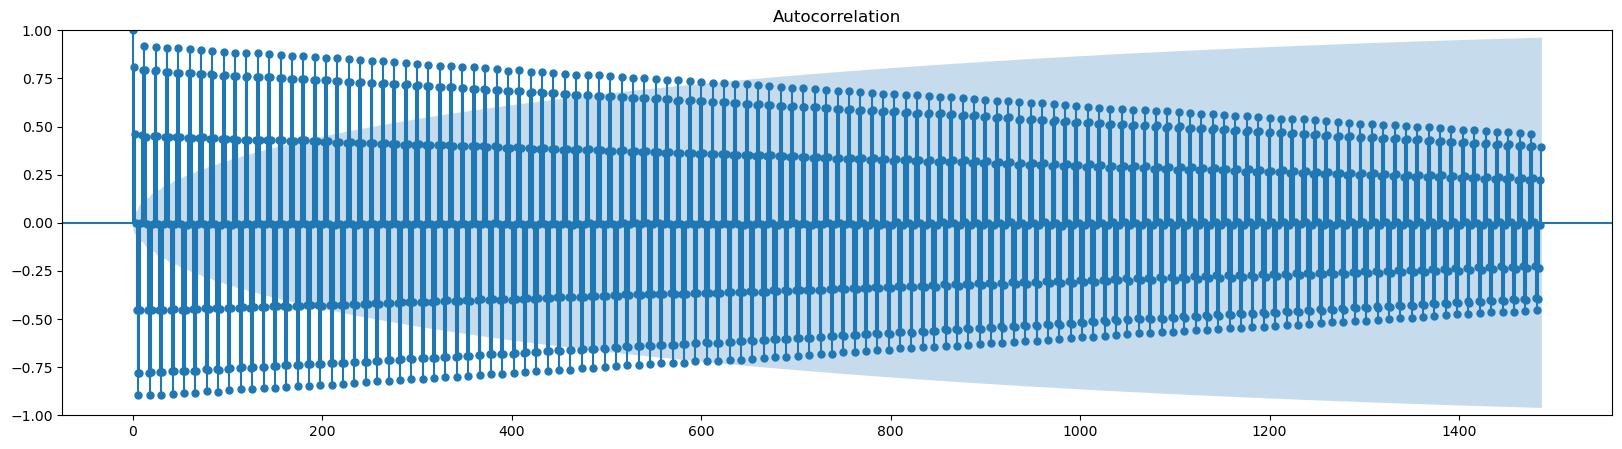

nz_tourist_monthly.json


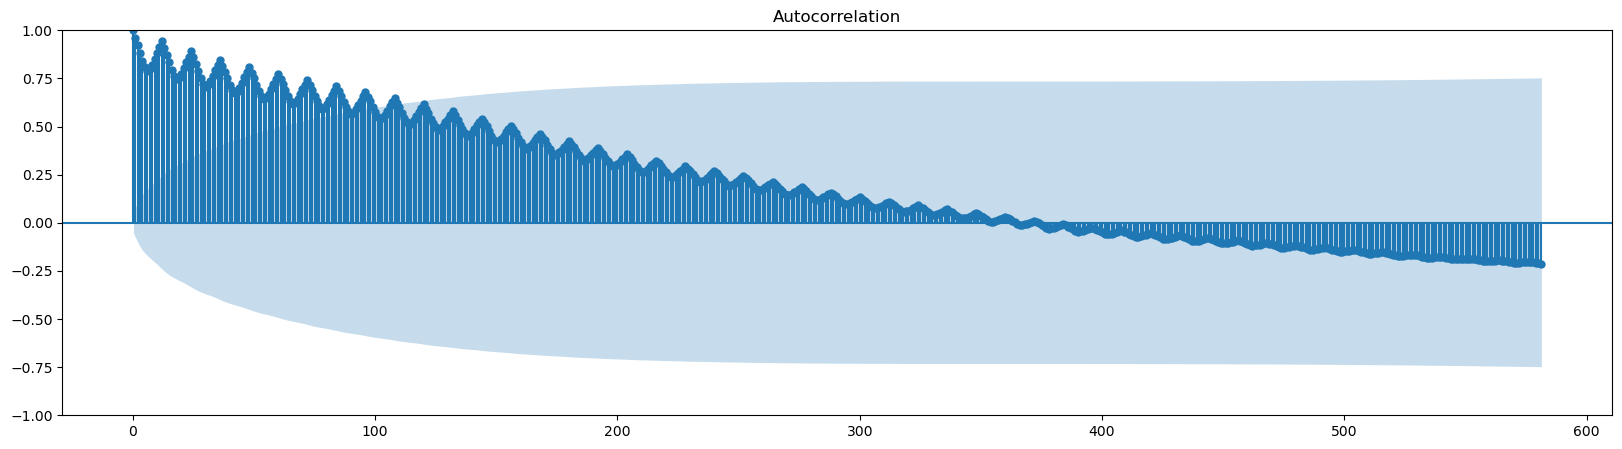

sine.csv


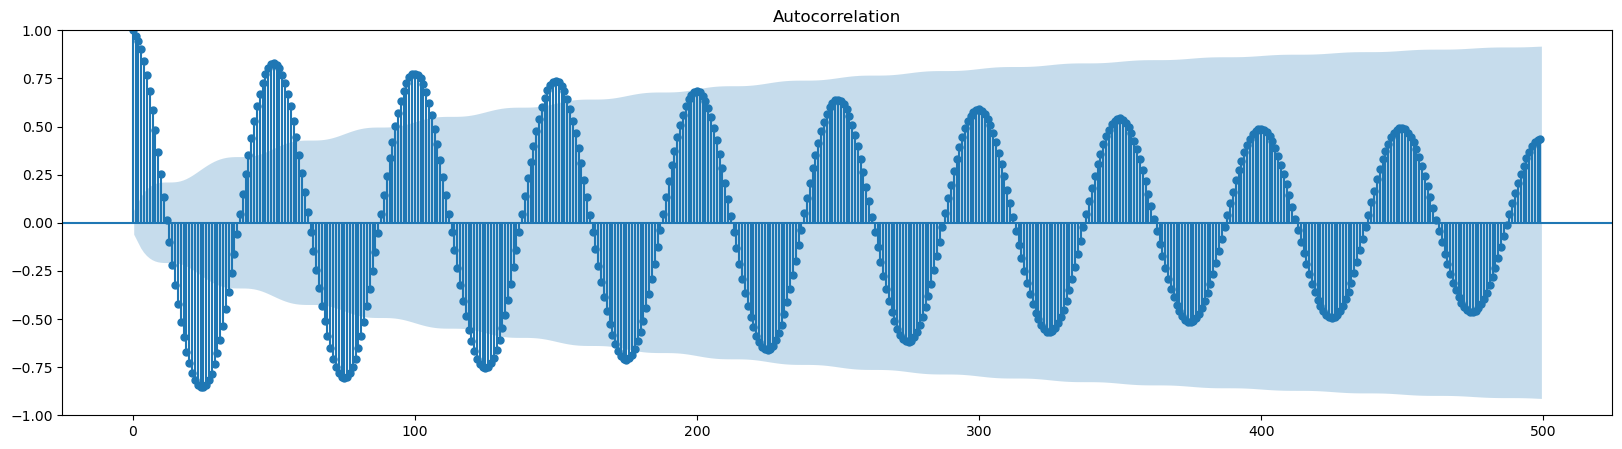

gasoline1.csv


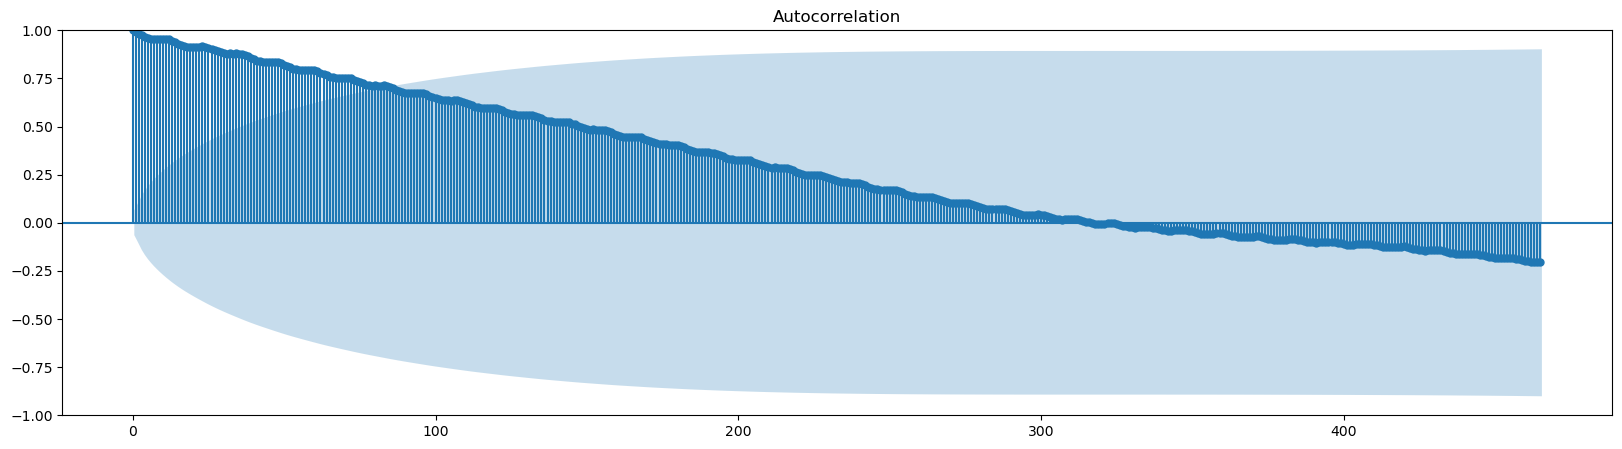

gasoline2.csv


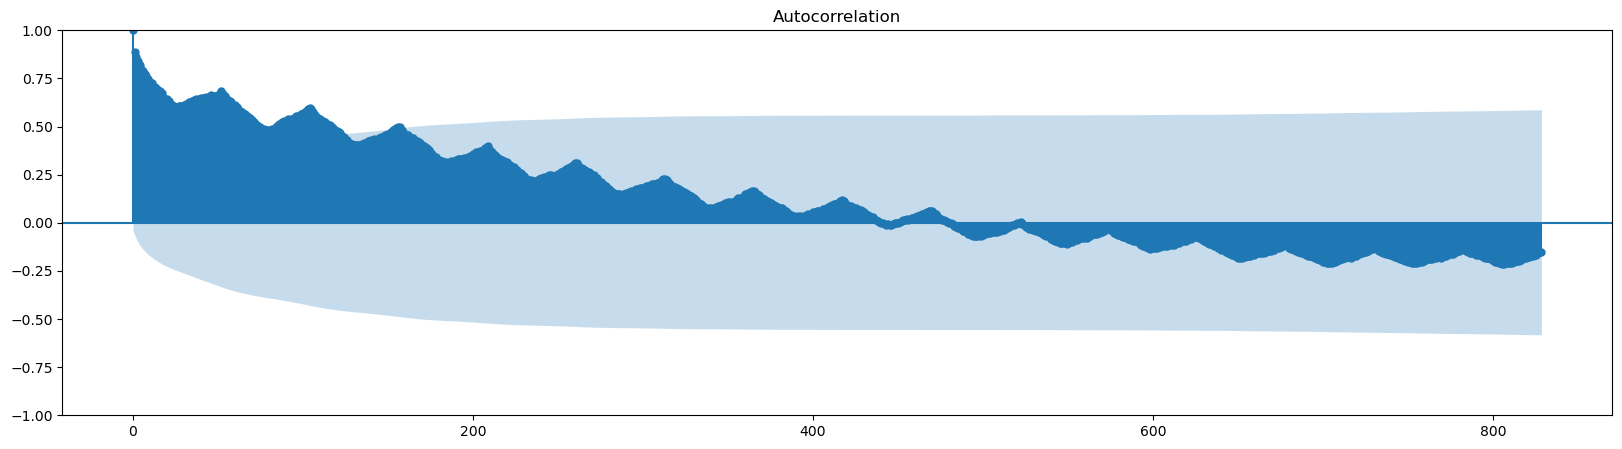

climate_jfk_tmax.json


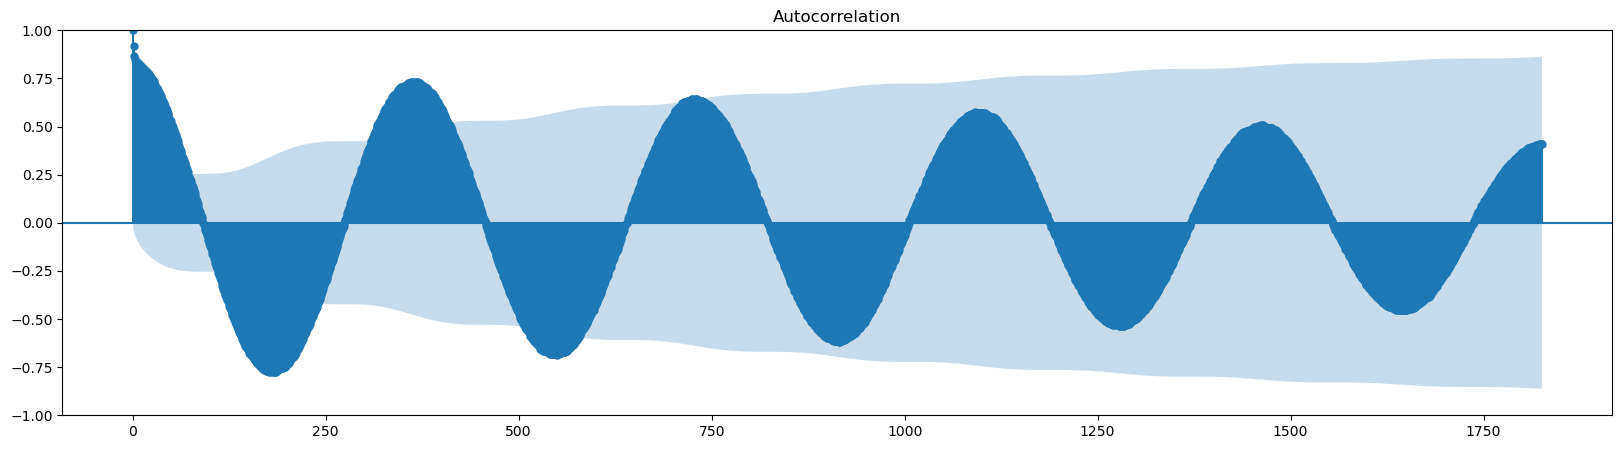

climate_lax_awnd.json


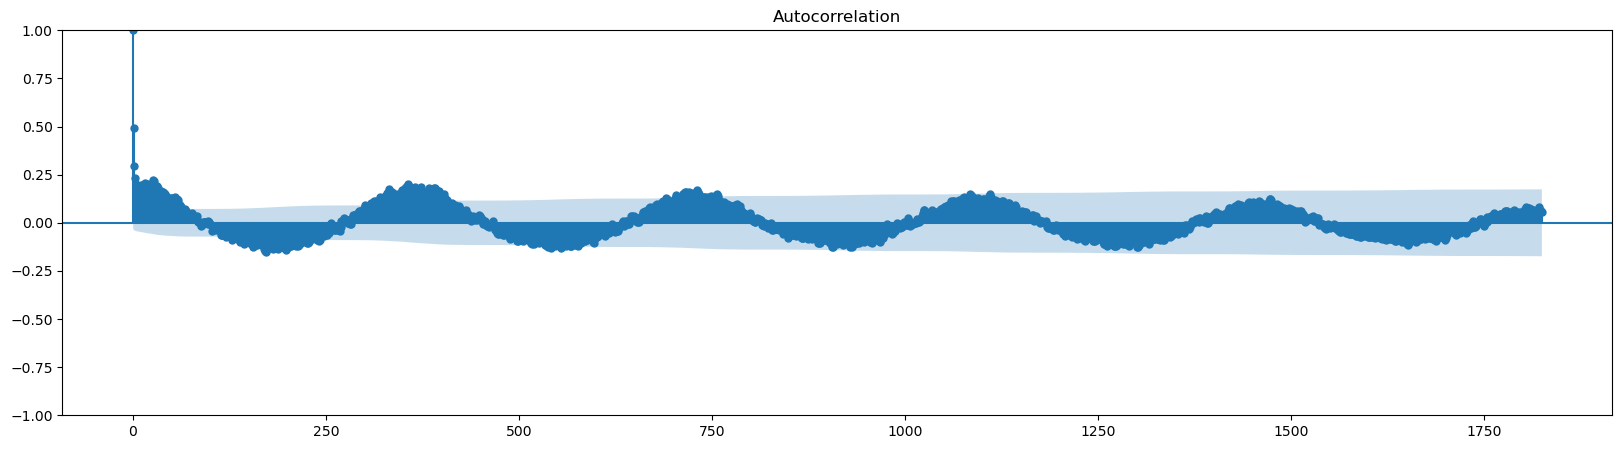

monthly_beer_austria.csv


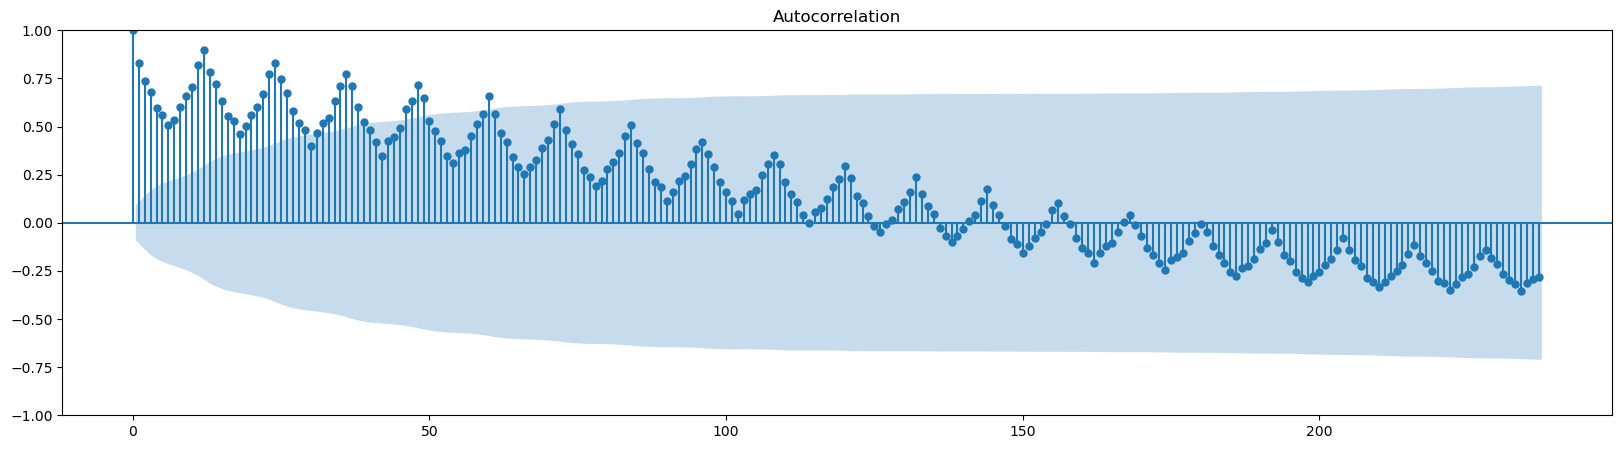

chi_homicide_weekly.json


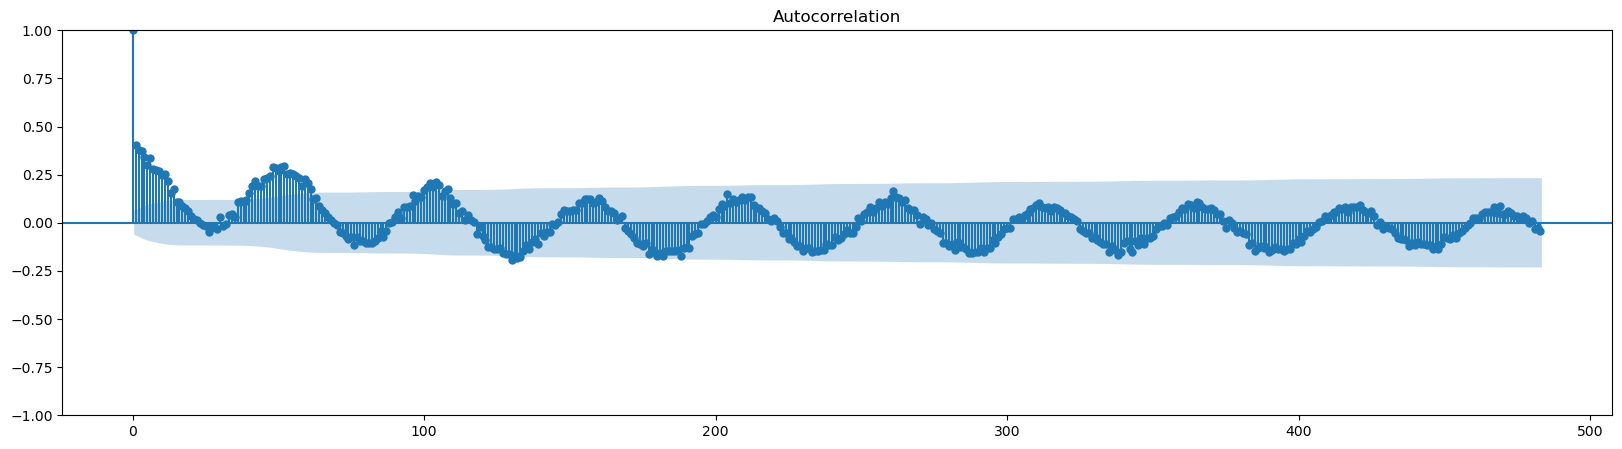

eeg_chan10_2500.json


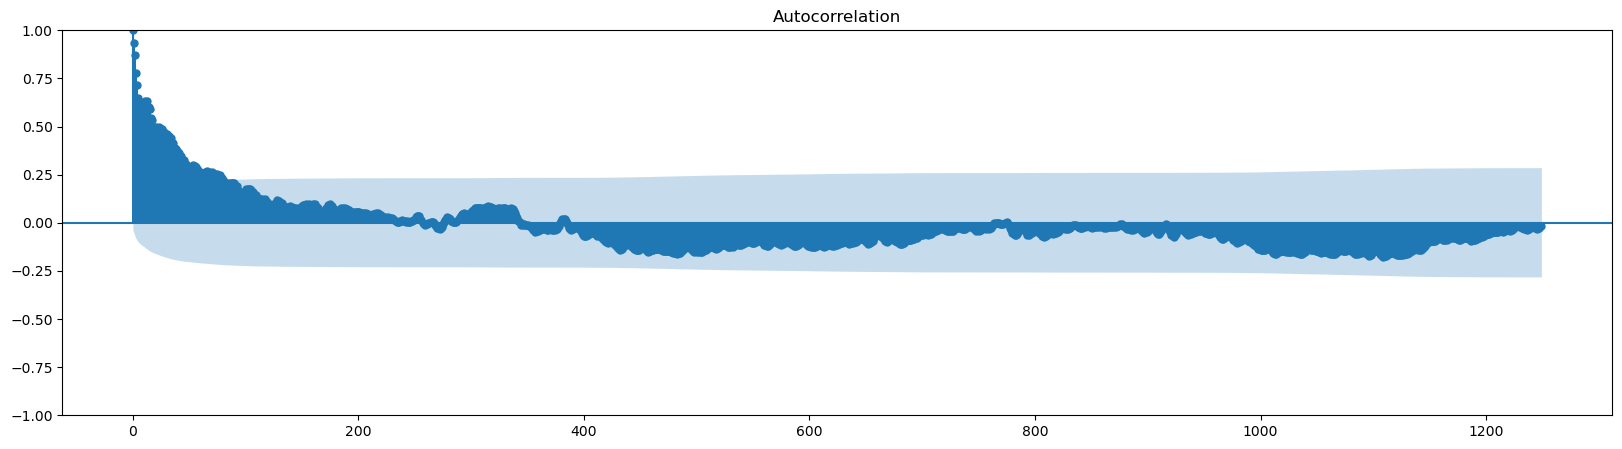

usa_flights_weekly.json


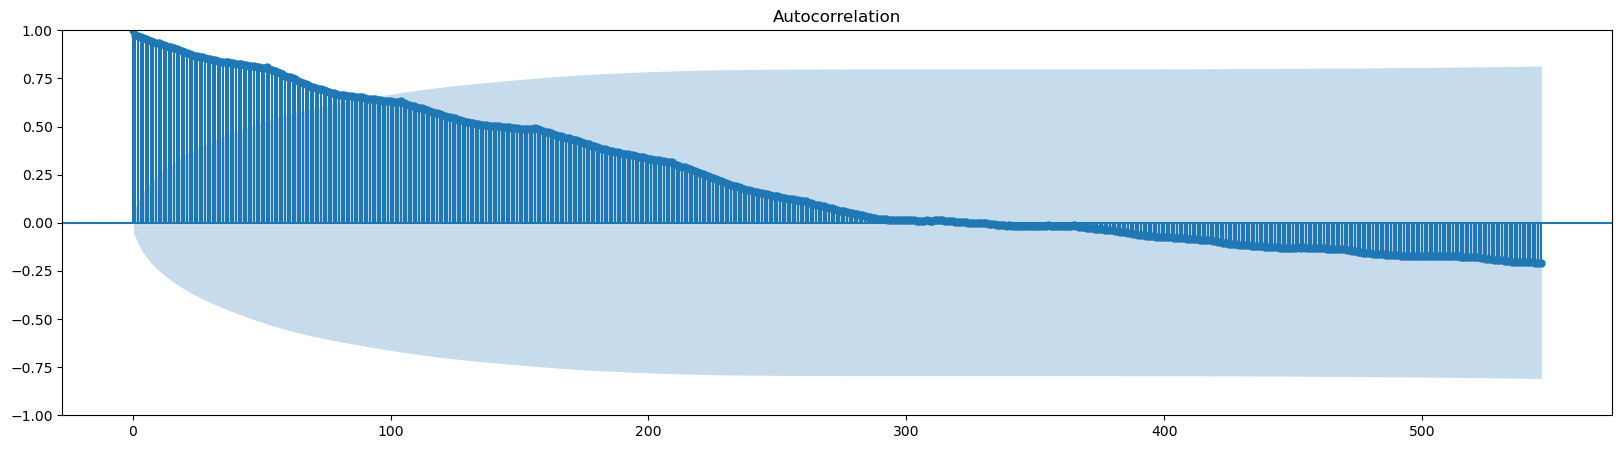

In [5]:
for dataset in filename_to_type:
    print(dataset)
    time_series = get_time_series(dataset, filename_to_type[dataset])
    plot_acf_wrapper(time_series, 0.5 * len(time_series)-1)

In [6]:
# Seasonal Decomposition
def plot_seasonal_decomposition(time_series, period):
    decomposition = seasonal_decompose(time_series, model='additive', period=period)
    fig = decomposition.plot()
    plt.show()
    # Return the trend, seasonal, and residual components
    return decomposition.trend, decomposition.seasonal, decomposition.resid

sine.csv


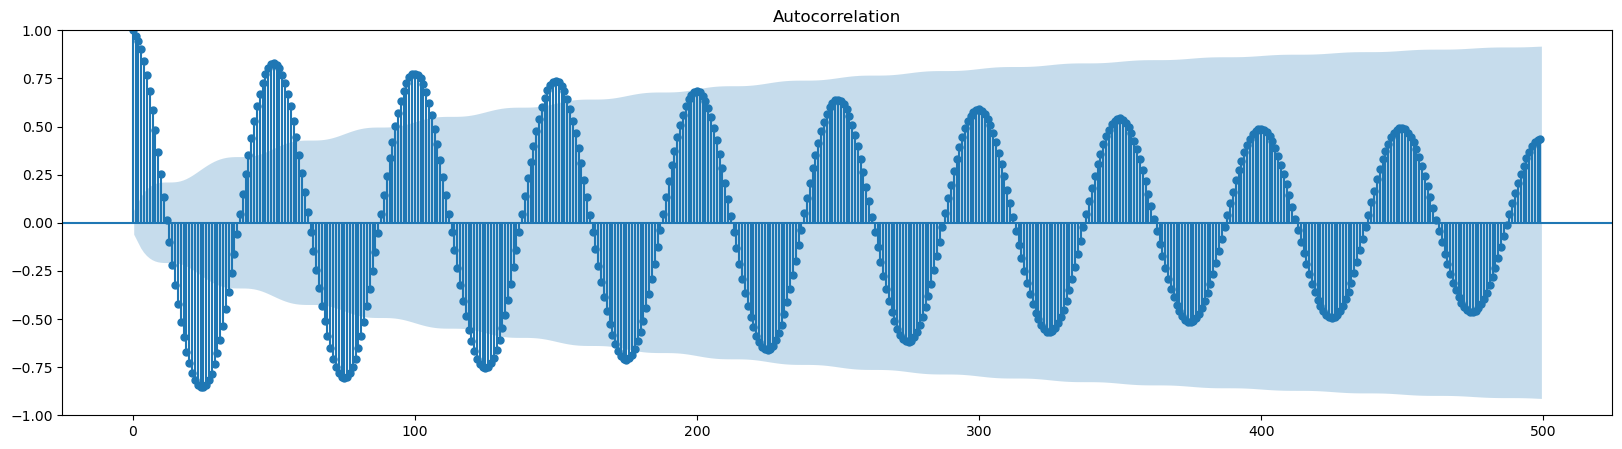

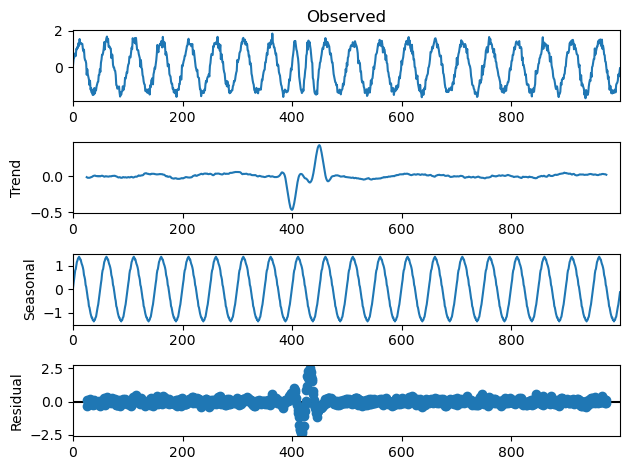

taxi.csv


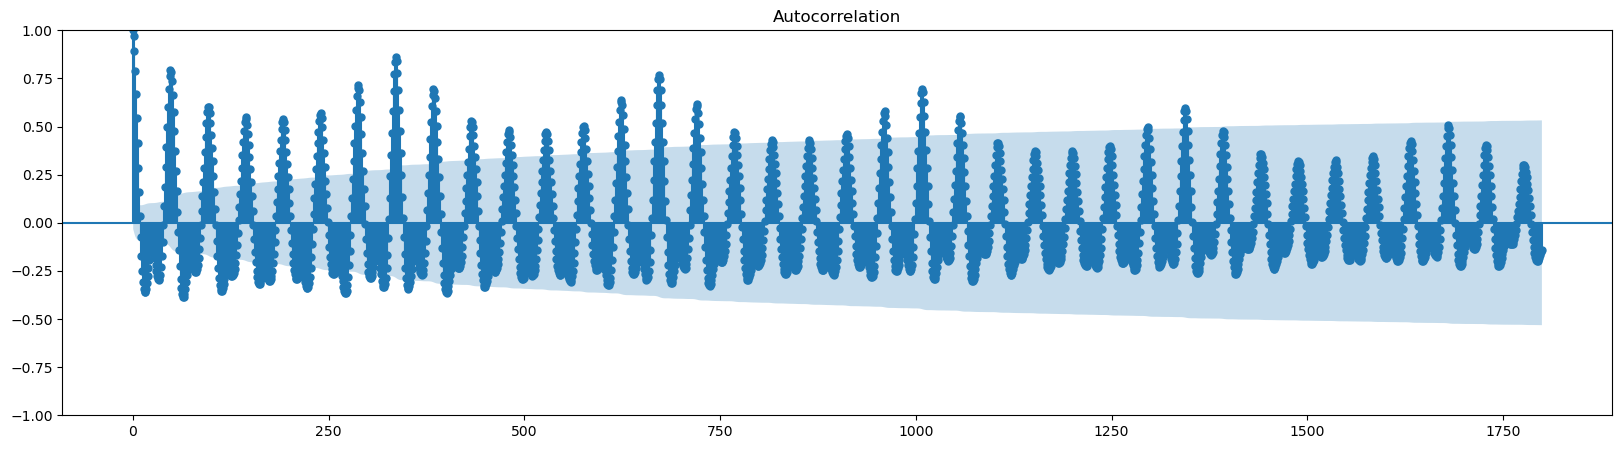

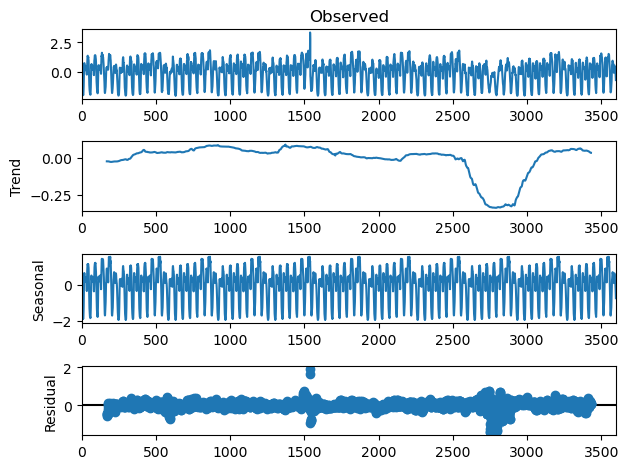

gasoline1.csv


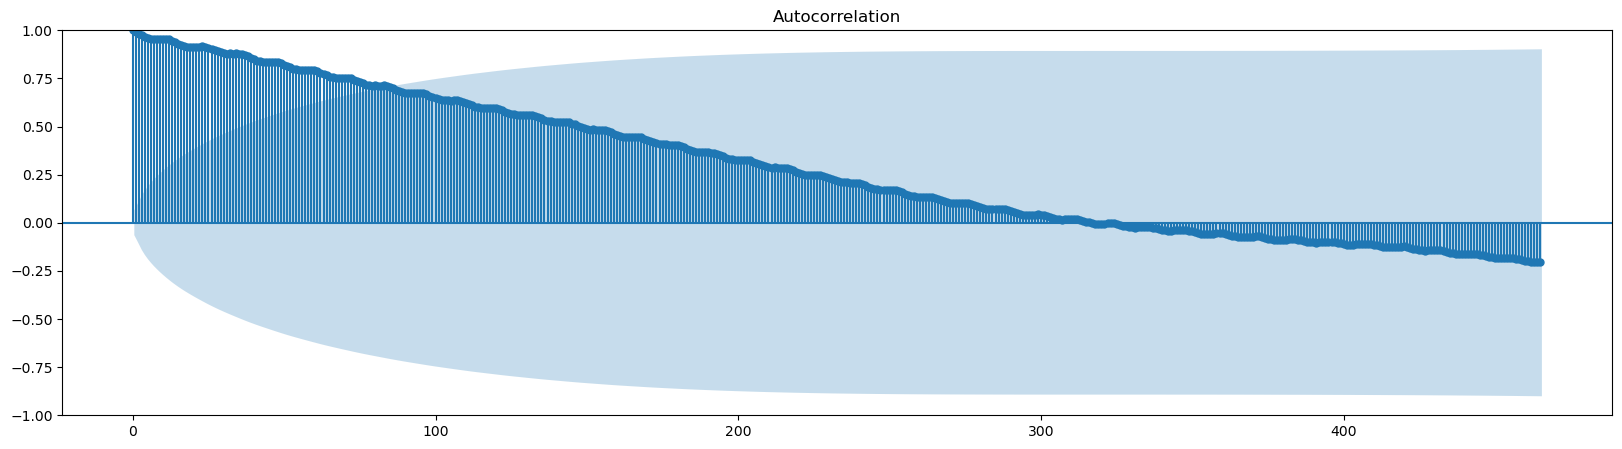

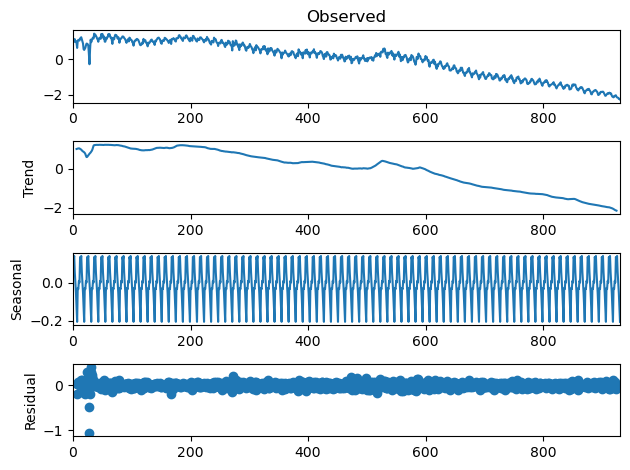

gasoline2.csv


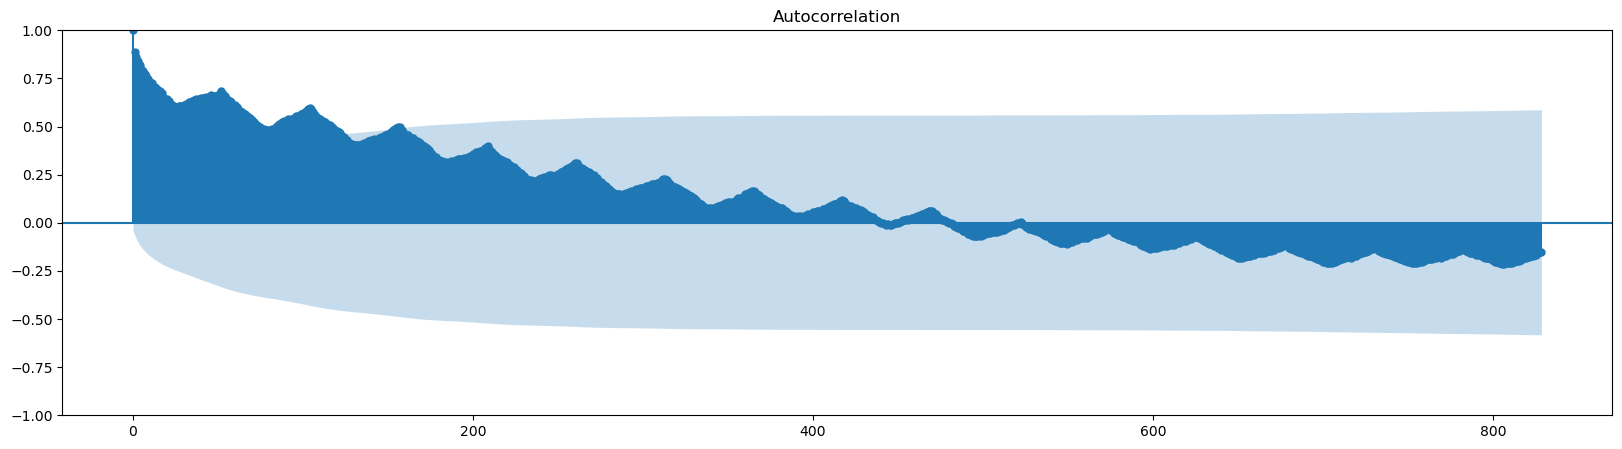

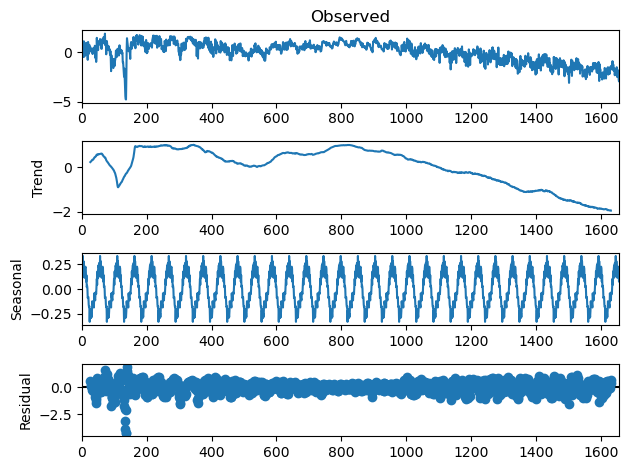

climate_jfk_tmax.json


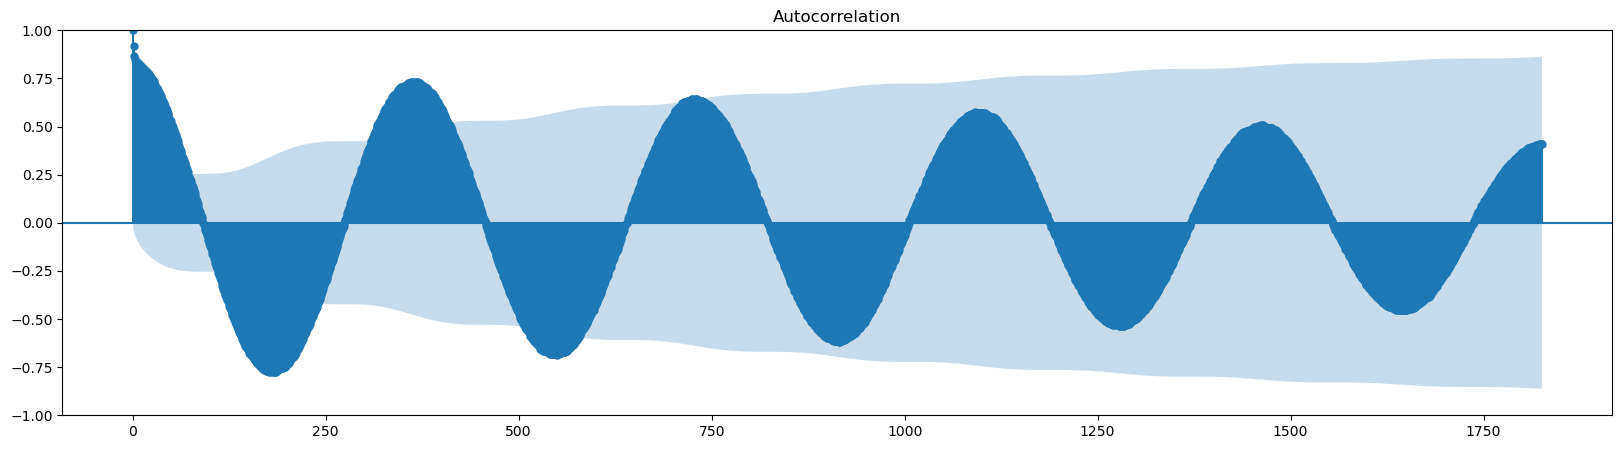

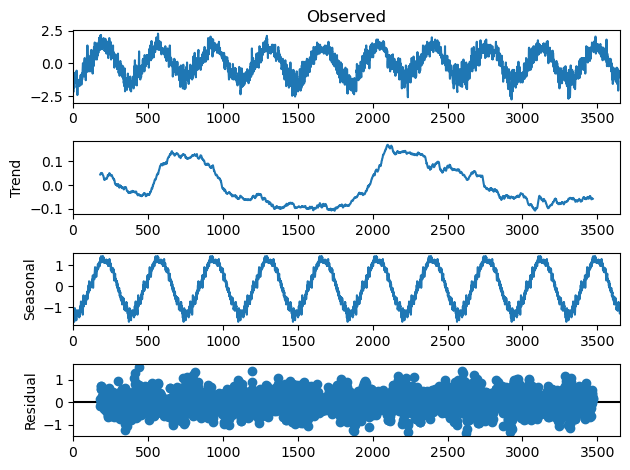

temp.csv


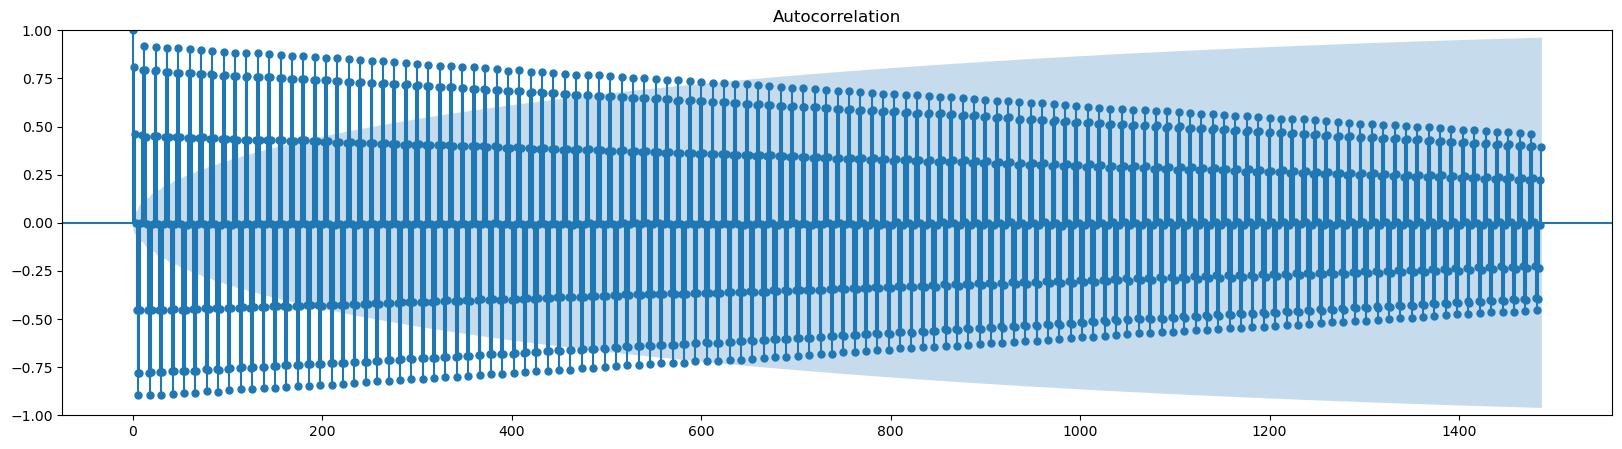

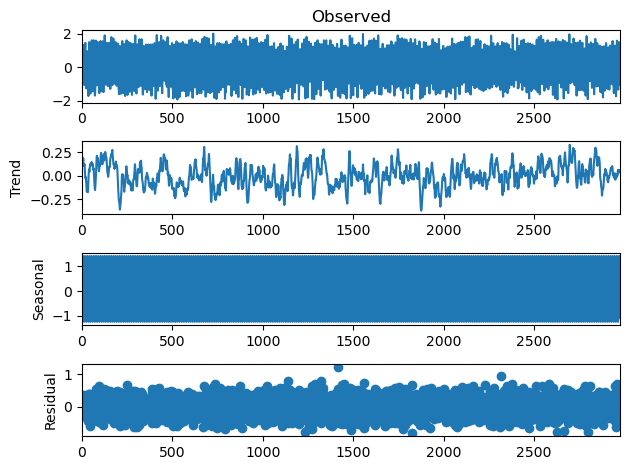

usa_flights_weekly.json


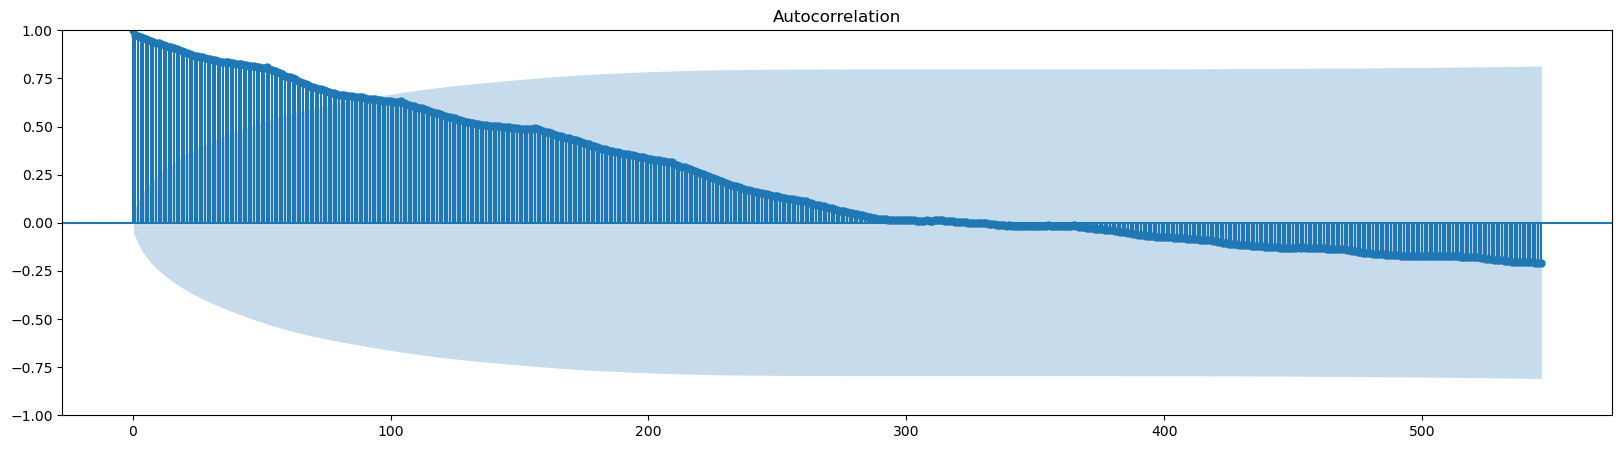

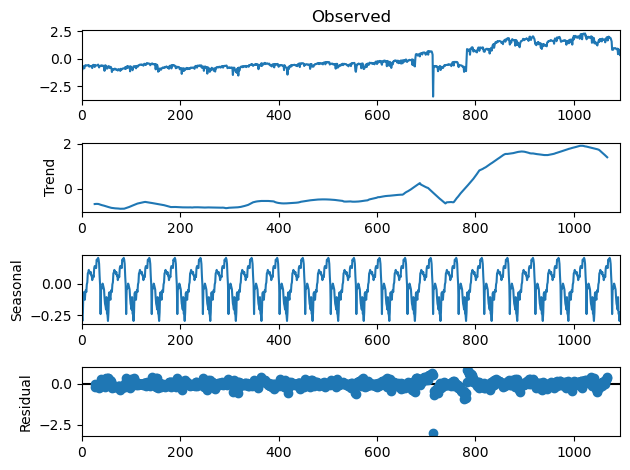

nz_tourist_monthly.json


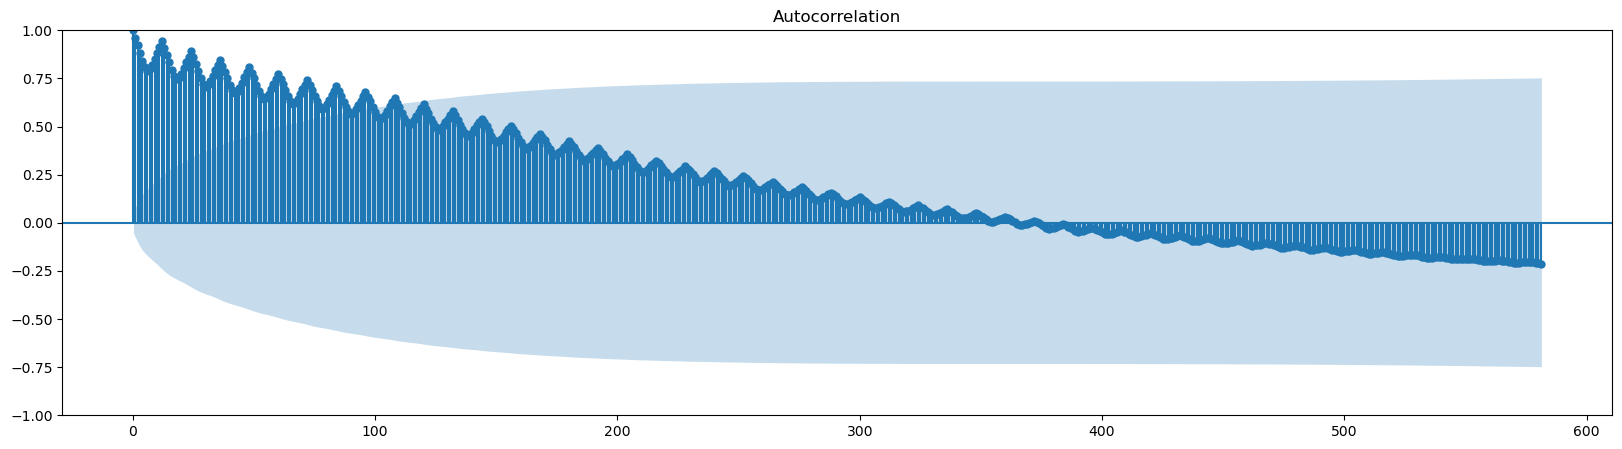

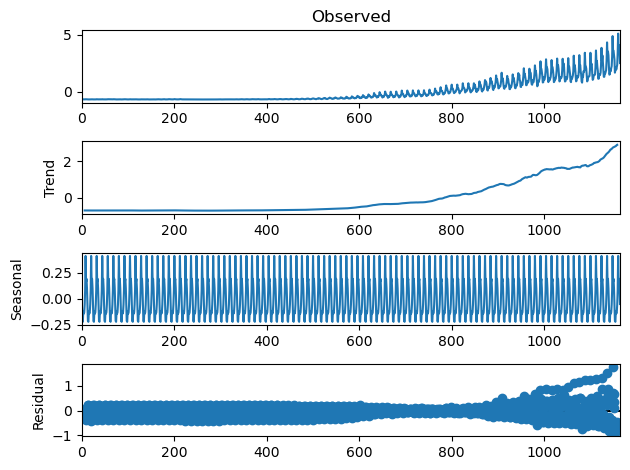

climate_lax_awnd.json


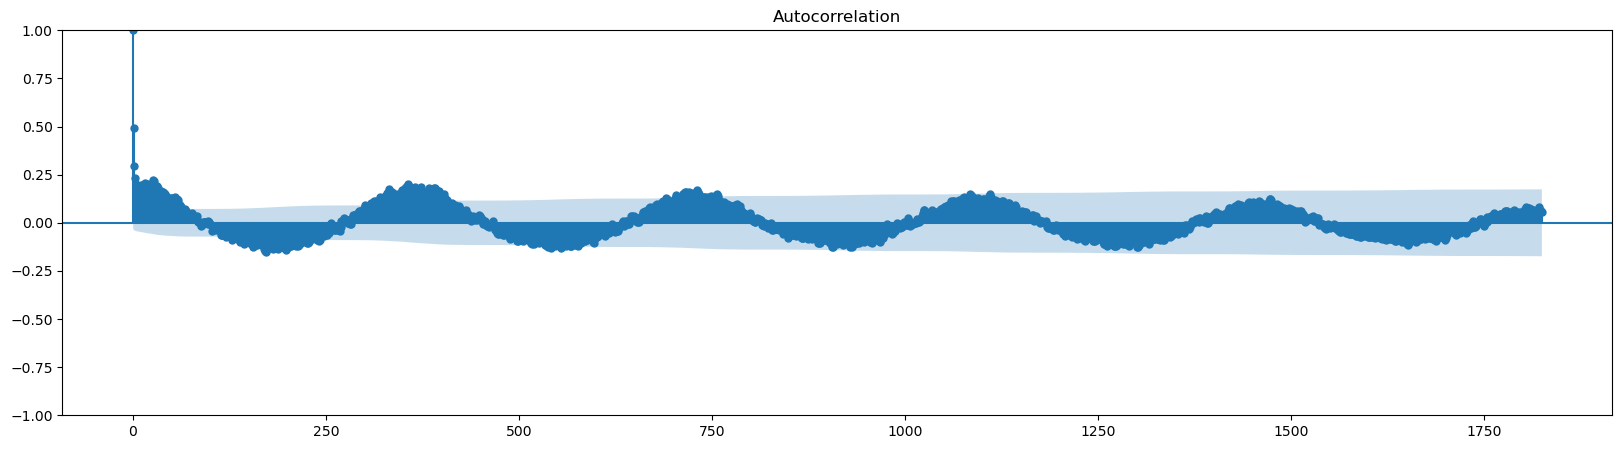

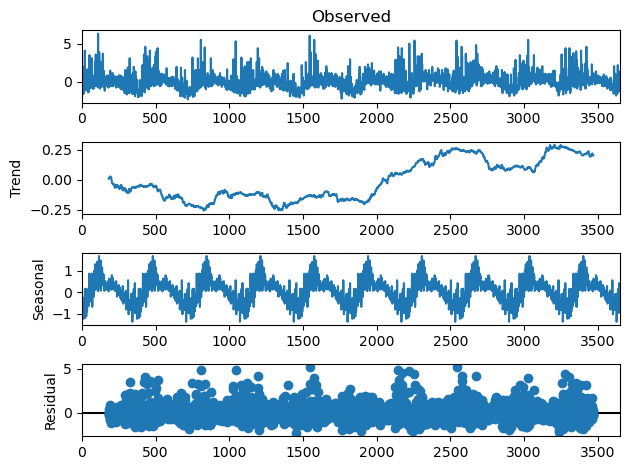

monthly_beer_austria.csv


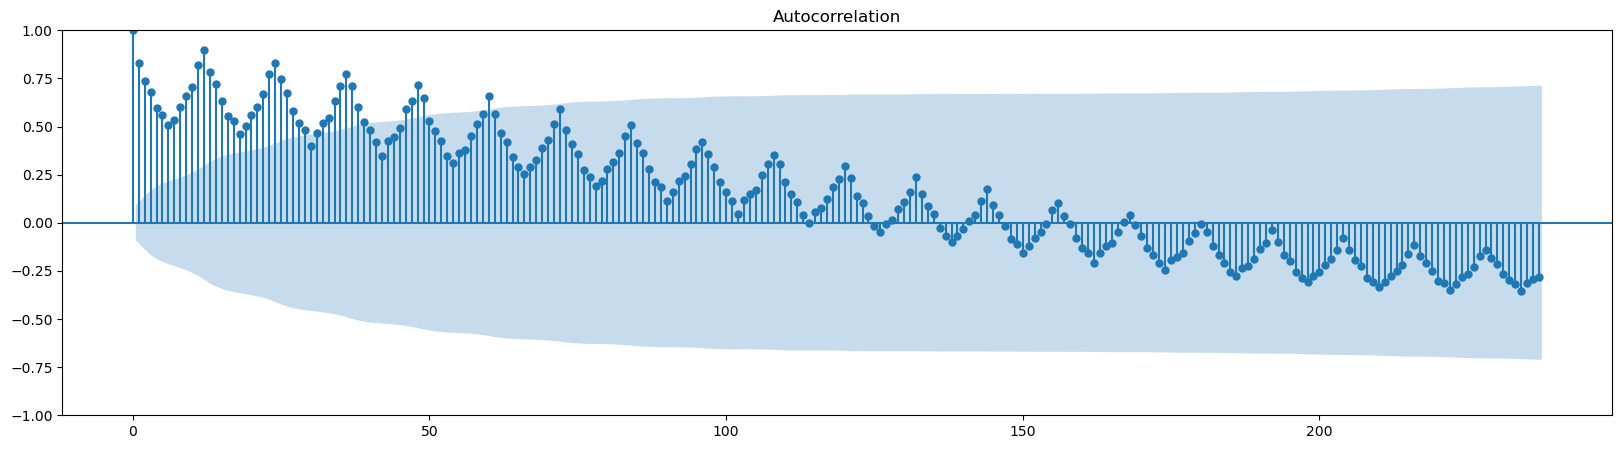

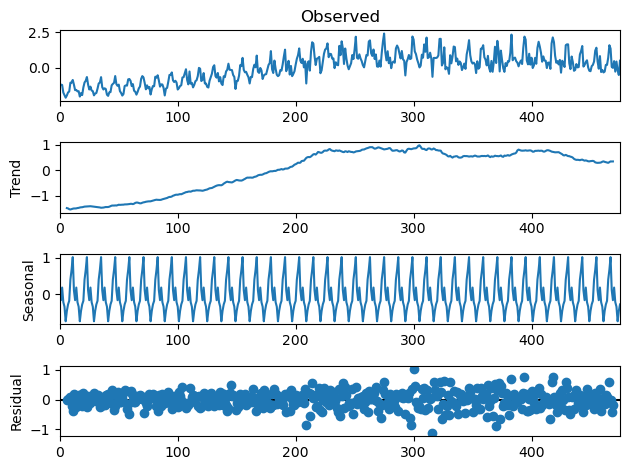

chi_homicide_weekly.json


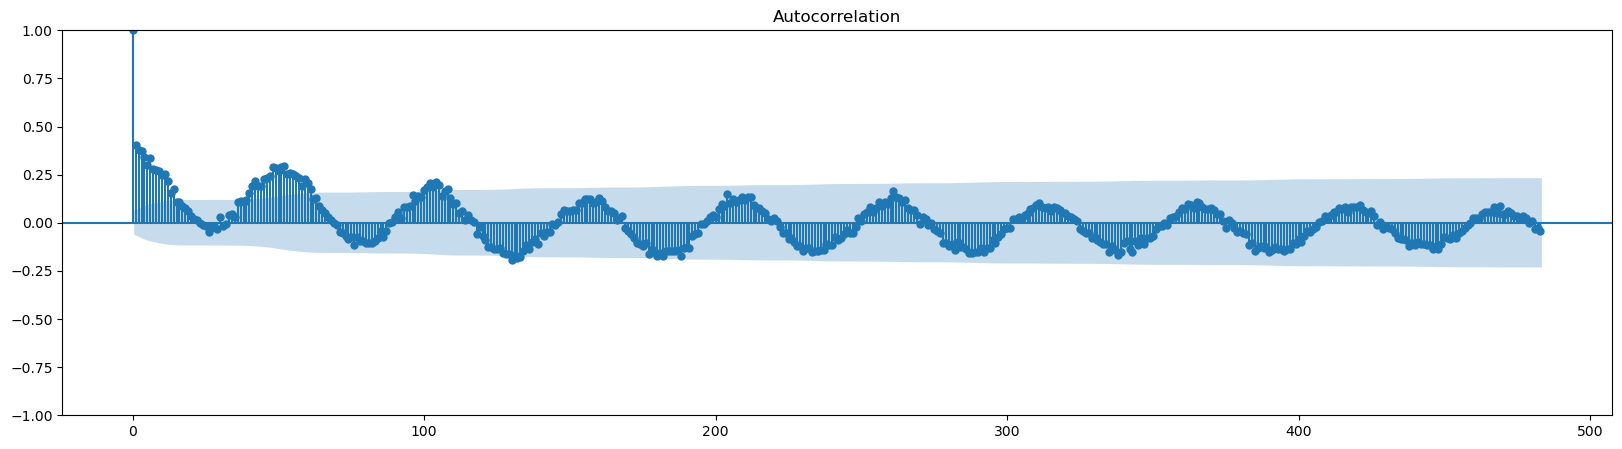

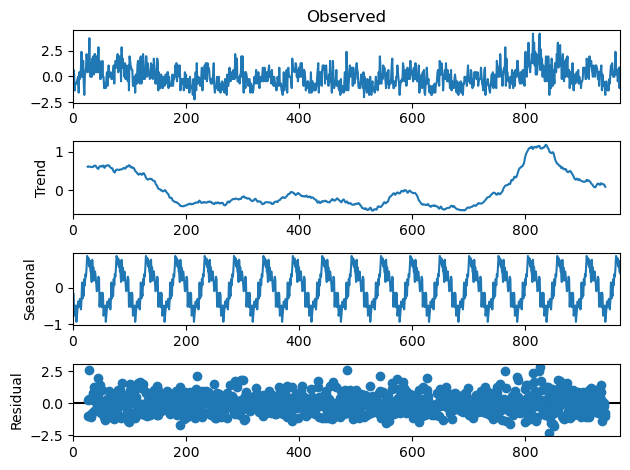

eeg_chan10_2500.json


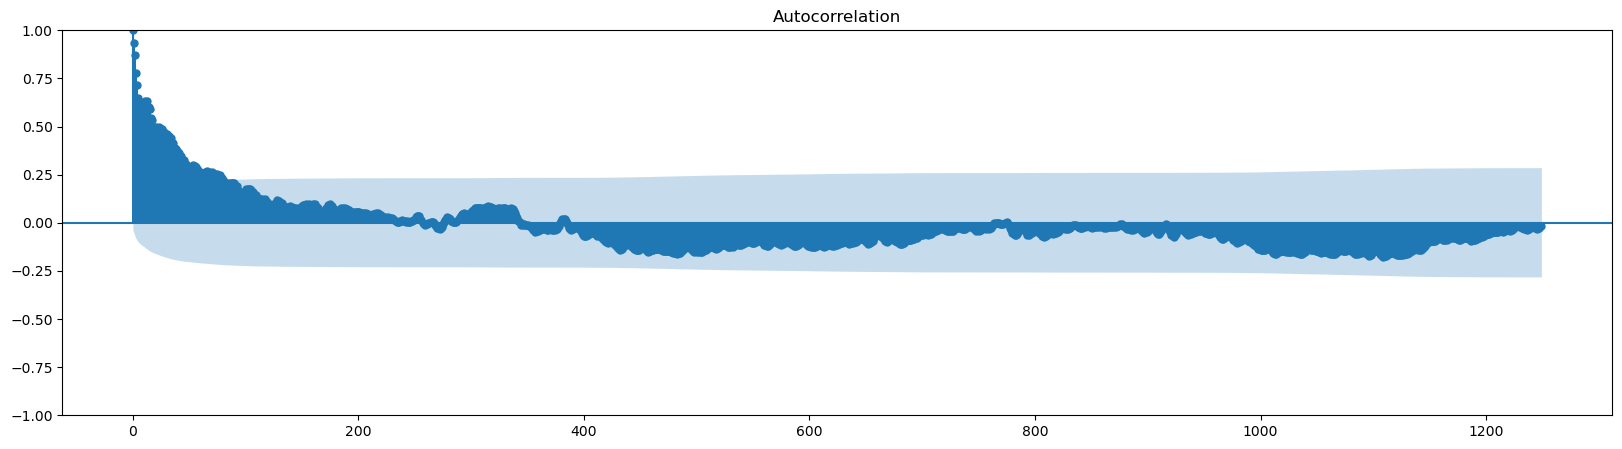

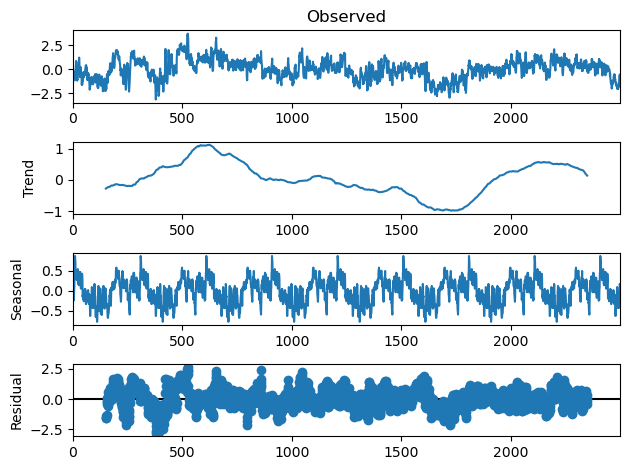

In [7]:
seasonal_datasets = {
    'sine.csv': 50,
    'taxi.csv': 336,
    'gasoline1.csv': 12,
    'gasoline2.csv': 53,
    'climate_jfk_tmax.json': 365,
    'temp.csv': 12,
    'usa_flights_weekly.json': 52,
    'nz_tourist_monthly.json': 12,
    'climate_lax_awnd.json': 365,
    'monthly_beer_austria.csv': 12,
    'chi_homicide_weekly.json': 52,
    'eeg_chan10_2500.json': 300,
}

class DatasetInfo:
    def __init__(self, name, trend, seasonality, noise):
        self.name = name
        self.trend = trend
        self.seasonality = seasonality
        self.noise = noise
        self.total = trend + seasonality + noise

dataset_infos = []

for dataset, period in seasonal_datasets.items():
    time_series = get_time_series(dataset, filename_to_type[dataset])
    print(dataset)
    plot_acf_wrapper(time_series, int(0.5 * len(time_series)) - 1)
    trend, seasonal, residual = plot_seasonal_decomposition(time_series, period)
    dataset_infos += [DatasetInfo(dataset, trend, seasonal, residual)]

In [12]:
def seasonality_strength(residual, seasonality):
    # Return max of 0 and 1 - residual variance / ((seasonality + residual) variance)
    return max(0, 1 - np.nanvar(residual) / np.nanvar(seasonality + residual))

In [13]:
# Sort the datasets by seasonality strength
dataset_infos.sort(key=lambda x: seasonality_strength(x.noise, x.seasonality), reverse=True)

# Print the datasets in order of seasonality strength
for dataset_info in dataset_infos:
    print(dataset_info.name, seasonality_strength(dataset_info.noise, dataset_info.seasonality))
    

taxi.csv 0.9626335741998814
temp.csv 0.9335064177095201
sine.csv 0.8704289843923103
climate_jfk_tmax.json 0.8404769460362692
monthly_beer_austria.csv 0.7581258277260832
gasoline1.csv 0.6793000445690858
nz_tourist_monthly.json 0.3513569976930577
chi_homicide_weekly.json 0.28249897167220017
climate_lax_awnd.json 0.2772301308617874
usa_flights_weekly.json 0.27350229780160906
eeg_chan10_2500.json 0.14360867095524277
gasoline2.csv 0.12342279178135729


# Feature Importance

In [9]:
# Construct the X and y matrices
X = []
y1 = []
y2 = []

dataset_to_y = {
    'taxi.csv': 'lowpass:kurtosis',
    'temp.csv': 'lowpass:kurtosis',
    'nz_tourist_monthly.json': 'mean:entropy',
    'sine.csv': 'exponential_smoothing:entropy',
    'gasoline1.csv': 'gaussian:kurtosis',
    'gasoline2.csv': 'exponential_smoothing:kurtosis',
    'climate_jfk_tmax.json': 'gaussian:kurtosis',
    'climate_lax_awnd.json': 'lowpass:kurtosis',
    'monthly_beer_austria.csv': 'exponential_smoothing:kurtosis',
    'chi_homicide_weekly.json': 'mean:kurtosis',
    'eeg_chan10_2500.json': 'mean:entropy',
    'usa_flights_weekly.json': 'exponential_smoothing:entropy',
}

for dataset in filename_to_type:
    time_series = get_time_series(dataset, filename_to_type[dataset])
    # Get features for the time series
    features = []
    # Mean
    features.append(np.mean(time_series))
    # Standard deviation
    features.append(np.std(time_series))
    # Kurtosis
    features.append(np.mean(np.power(time_series, 4)) / np.power(np.mean(np.power(time_series, 2)), 2))
    # Skewness
    features.append(np.mean(np.power(time_series, 3)) / np.power(np.mean(np.power(time_series, 2)), 1.5))
    # Autocorrelation at lag 1
    features.append(np.corrcoef(time_series[:-1], time_series[1:])[0, 1])
    # Autocorrelation at lag 2
    features.append(np.corrcoef(time_series[:-2], time_series[2:])[0, 1])
    # Length of the time series
    features.append(len(time_series))

    # Add the features to the X matrix
    X.append(features)
    # Add the label to the y1 matrix and y2 matrix
    y1.append(dataset_to_y[dataset].split(':')[0])
    y2.append(dataset_to_y[dataset].split(':')[1])

# PCA 

